In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Subset, DataLoader

import torchvision
from torchvision import utils
from torchvision import models
from torchvision import datasets
from torchvision import transforms

from torchsummary import summary
from sklearn.model_selection import StratifiedShuffleSplit

import os
import copy
import yaml
import collections
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

In [2]:
with open('hyperparameters.yaml') as f:
    hp = yaml.safe_load(f)['hyperparameters']

In [3]:
data_transformer = transforms.Compose([
    transforms.ToTensor()
])

train_ds = datasets.STL10('./data', split='train', download=True,transform=data_transformer)
train_ds.data.shape

Files already downloaded and verified


(5000, 3, 96, 96)

In [4]:
y_train = [y for _,y in train_ds]
counter_train = collections.Counter(y_train)
counter_train

Counter({1: 500,
         5: 500,
         6: 500,
         3: 500,
         9: 500,
         7: 500,
         4: 500,
         8: 500,
         0: 500,
         2: 500})

In [5]:
test0_ds = datasets.STL10('./data', split='test', download=True,transform=data_transformer)
test0_ds.data.shape

Files already downloaded and verified


(8000, 3, 96, 96)

In [6]:
shuffle = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices = list(range(len(test0_ds)))
y_test0 = [y for _,y in test0_ds]
for test_index, val_index in shuffle.split(indices, y_test0):
    print("test:", test_index, "val:", val_index)
    print(len(val_index),len(test_index))

test: [2096 4321 2767 ... 3206 3910 2902] val: [6332 6852 1532 ... 5766 4469 1011]
1600 6400


In [7]:
val_ds = Subset(test0_ds,val_index)
test_ds = Subset(test0_ds,test_index)

print(len(val_ds))
print(len(test_ds))

1600
6400


In [8]:
y_test = [y for _,y in test_ds]
y_val = [y for _,y in val_ds]

counter_test = collections.Counter(y_test)
counter_val = collections.Counter(y_val)

print(counter_val)
print(counter_test)

Counter({2: 160, 8: 160, 3: 160, 6: 160, 4: 160, 1: 160, 5: 160, 9: 160, 0: 160, 7: 160})
Counter({6: 640, 0: 640, 4: 640, 5: 640, 9: 640, 2: 640, 3: 640, 1: 640, 7: 640, 8: 640})


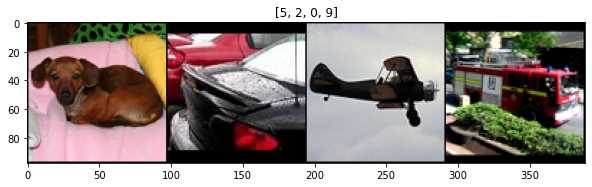

In [9]:
np.random.seed(0)

def show(img, label=None):
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    plt.imshow(img)
    if label is not None:
        plt.title(label)

img_idx = np.random.randint(0, len(train_ds), 4)

img_X = [train_ds[i][0] for i in img_idx]
img_y = [train_ds[i][1] for i in img_idx]
grid = utils.make_grid(img_X, nrow=4, padding=1)

plt.figure(figsize=(10, 10))
show(grid, img_y)

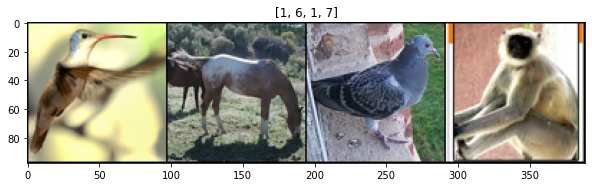

In [10]:
np.random.seed(0)

img_idx_v = np.random.randint(0, len(val_ds), 4)

img_X_v = [val_ds[i][0] for i in img_idx_v]
img_y_v = [val_ds[i][1] for i in img_idx_v]
grid_v = utils.make_grid(img_X_v, nrow=4, padding=1)

plt.figure(figsize=(10, 10))
show(grid_v, img_y_v)

In [11]:
mean_rgb = [np.mean(img.numpy(), axis=(1, 2)) for img, _ in train_ds]
std_rgb = [np.std(img.numpy(), axis=(1, 2)) for img, _ in train_ds]

mean_r, mean_g, mean_b = [np.mean([m[i] for m in mean_rgb]) for i in range(3)]
std_r, std_g, std_b = [np.mean([s[i] for s in std_rgb]) for i in range(3)]

In [12]:
print(f'Mean - R: {mean_r:.4f} G: {mean_g:.4f} B: {mean_b:.4f}')
print(f'StdDev - R: {std_r:.4f} G: {std_g:.4f} B: {std_b:.4f}')

Mean - R: 0.4467 G: 0.4398 B: 0.4066
StdDev - R: 0.2241 G: 0.2215 B: 0.2239


In [13]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5)
    , transforms.RandomVerticalFlip(p=0.5)
    , transforms.ToTensor()
    , transforms.Normalize(mean=[mean_r, mean_g, mean_b], std=[std_r, std_g, std_b])
])

test_transform = transforms.Compose([
    transforms.ToTensor()
    , transforms.Normalize(mean=[mean_r, mean_g, mean_b], std=[std_r, std_g, std_b])
])

In [14]:
train_ds.transform = train_transform
test0_ds.transform = test_transform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


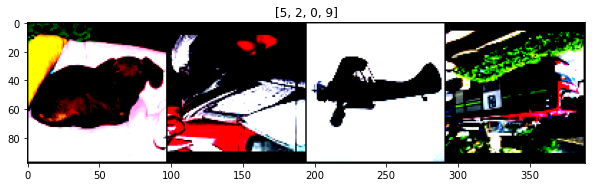

In [15]:
np.random.seed(0)

img_idx_n = np.random.randint(0, len(train_ds), 4)

img_X_n = [train_ds[i][0] for i in img_idx_n]
img_y_n = [train_ds[i][1] for i in img_idx_n]
grid_n = utils.make_grid(img_X_n, nrow=4, padding=1)

plt.figure(figsize=(10, 10))
show(grid_n, img_y_n)

In [16]:
batch_size = hp['batch_size']

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [17]:
for data, _ in train_dl:
    print(data.shape) # batch size, channels, height, width
    break

torch.Size([512, 3, 96, 96])


In [18]:
net = models.resnet18(pretrained=True).cuda()
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
summary(net, input_size=(3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [20]:
num_classes = 10
num_ftrs = net.fc.in_features 
net.fc = nn.Linear(num_ftrs, num_classes).cuda()

In [21]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(params=net.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=1)

In [22]:
def batch_accuracy(output: torch.Tensor, target: torch.Tensor):
    prediction = output.argmax(dim=1, keepdim=True)
    correct = prediction.eq(target.view_as(prediction)).sum().item()
    return correct

In [23]:
def batch_loss(criterion, output, target, optimizer=None):
    loss = criterion(output, target)
    accuracy = batch_accuracy(output, target)

    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), accuracy

In [24]:

def epoch_loss(net, criterion, dataset, optimizer=None):
    total_loss = 0.
    total_acc = 0.

    for data, target in dataset:
        data = data.cuda()
        target = target.cuda()

        output = net(data)
        loss, acc = batch_loss(criterion, output, target, optimizer)
        total_loss += loss

        if acc is not None:
            total_acc += acc

    loss = total_loss / float(len(dataset.dataset))
    acc = total_acc / float(len(dataset.dataset))

    return loss, acc

In [25]:
params = {
    'epochs': hp['epochs'],
    'criterion': criterion,
    'optimizer': optimizer,
    'train_dl': train_dl,
    'val_dl': val_dl,
    'scheduler': scheduler,
    'save_loc': './weights/weights.pt',
}

history = {
    'train': {
        'loss': [],
        'acc': []
    },
    'val': {
        'loss': [],
        'acc': []
    }
}

def train(net, params):
    epochs = params['epochs']
    criterion = params['criterion']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    scheduler = params['scheduler']
    save_loc = params['save_loc']
    weights = copy.deepcopy(net.state_dict())
    best_loss = float('inf')

    # train loop
    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        print(f'Train Epoch: {epoch + 1}/{epochs}\tLR: {lr}')

        # train
        net.train()
        loss_t, acc_t = epoch_loss(net, criterion, train_dl, optimizer)
        history['train']['loss'].append(loss_t)
        history['train']['acc'].append(acc_t)

        # eval
        net.eval()
        with torch.no_grad():
            loss_v, acc_v = epoch_loss(net, criterion, val_dl)
        history['val']['loss'].append(loss_v)
        history['val']['acc'].append(acc_v)

        if loss_v < best_loss:
            best_loss = loss_v
            weights = copy.deepcopy(net.state_dict())
            torch.save(weights, save_loc)
            print(f'Weights saved. Loss: {best_loss:.3f}')

        scheduler.step(loss_v)
        if lr != optimizer.param_groups[0]['lr']:
            net.load_state_dict(weights)
            print("Weights being loaded ...")

        print(f'Train loss: {loss_t:.3f}{" " * 5}Val loss: {loss_v:.3f}{" " * 5}Val acc: {acc_v * 100:.3f}')
        print('-' * 15)

    net.load_state_dict(weights)

    return net # trained model

In [26]:
trained_net = train(net, params)

Train Epoch: 1/50	LR: 0.0001
Weights saved. Loss: 0.897
Train loss: 1.691     Val loss: 0.897     Val acc: 70.438
---------------
Train Epoch: 2/50	LR: 0.0001
Weights saved. Loss: 0.603
Train loss: 0.771     Val loss: 0.603     Val acc: 79.188
---------------
Train Epoch: 3/50	LR: 0.0001
Weights saved. Loss: 0.452
Train loss: 0.503     Val loss: 0.452     Val acc: 84.188
---------------
Train Epoch: 4/50	LR: 0.0001
Weights saved. Loss: 0.405
Train loss: 0.368     Val loss: 0.405     Val acc: 85.750
---------------
Train Epoch: 5/50	LR: 0.0001
Weights saved. Loss: 0.380
Train loss: 0.286     Val loss: 0.380     Val acc: 86.375
---------------
Train Epoch: 6/50	LR: 0.0001
Weights saved. Loss: 0.357
Train loss: 0.219     Val loss: 0.357     Val acc: 86.875
---------------
Train Epoch: 7/50	LR: 0.0001
Weights saved. Loss: 0.352
Train loss: 0.167     Val loss: 0.352     Val acc: 87.812
---------------
Train Epoch: 8/50	LR: 0.0001
Weights saved. Loss: 0.340
Train loss: 0.128     Val loss: 0.

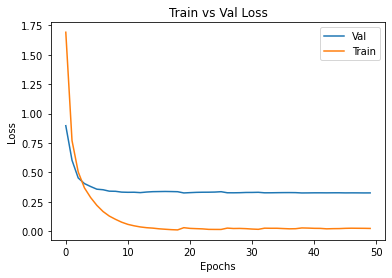

In [27]:
plt.clf()
plt.title('Train vs Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history['val']['loss'], label='Val')
plt.plot(history['train']['loss'], label='Train')
plt.legend()
plt.show()

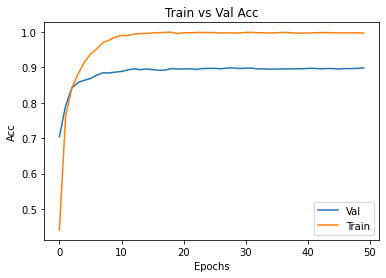

In [28]:
plt.clf()
plt.title('Train vs Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.plot(history['val']['acc'], label='Val')
plt.plot(history['train']['acc'], label='Train')
plt.legend()
plt.show()

In [29]:
avg_loss = np.mean(history['val']['loss'])

print(f'Average loss: {avg_loss}')


Average loss: 0.3523082396507264
